In [43]:
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from datetime import timedelta
from fbprophet import Prophet

%matplotlib inline

In [172]:
df = pd.read_csv('HU01_113010014_299_monthly.csv')
df['ds'] = pd.to_datetime(df['ds'],format='%Y-%m-%d')

In [173]:
df.head()

,ds,y
0,2015-01-01,23.0
1,2015-02-01,74.0
2,2015-03-01,175.0
3,2015-04-01,210.0
4,2015-05-01,189.0


The Below is the monthly Data of one item sold at one store.

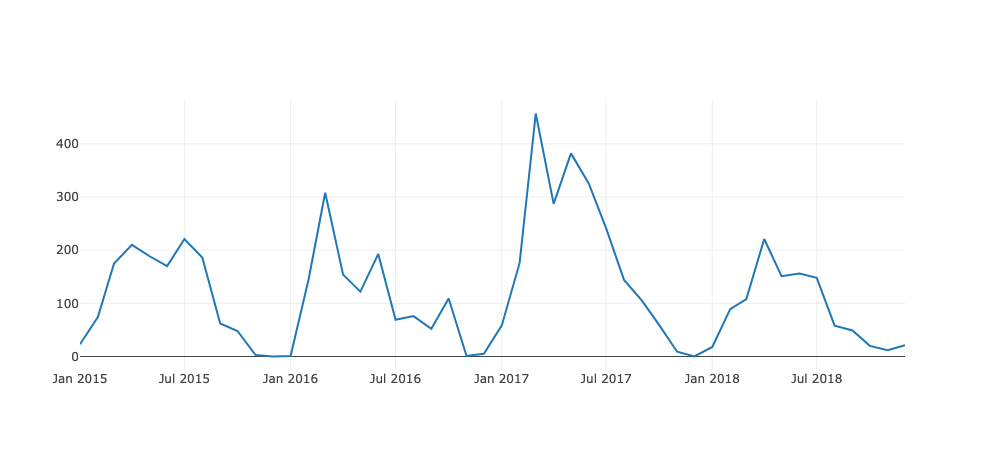

In [174]:
trace_actuals = go.Scatter(x=df.ds.dt.date , y = df.y,name='actuals')
iplot([trace_actuals])

In [175]:
def split_test_train(df,date):
    df_train = df[df['ds']<date]
    df_test = df[df['ds']>=date]
    return df_test,df_train

In [321]:
#  These are the actual holiday dates

holi_festival_actual_dates = pd.DataFrame({
  'holiday': 'holi_festival',
  'ds': pd.to_datetime([ '2015-03-05','2016-03-23', '2017-03-12','2018-03-01'])
})
dussera_actual_dates = pd.DataFrame({
  'holiday': 'dussera',
  'ds': pd.to_datetime(['2015-10-22', '2016-10-11', '2017-09-30', '2018-10-19'])
})

holidays_actual_dates = pd.concat((holi_festival_actual_dates, dussera_actual_dates))
holi_festival_actual_dates.head()

,holiday,ds
0,holi_festival,2015-03-05
1,holi_festival,2016-03-23
2,holi_festival,2017-03-12
3,holi_festival,2018-03-01


In [350]:
# Instead of actual holiday dates, I am mentioning the month start date
# example if a holiday is '2018-04-12' i am replacing it with '2018-04-01' (YYYY-MM-DD).

# I am doing this because if i give actual holiday dates
# prophet doest pick it up which can be visualised after we fit the model

holi_festival = pd.DataFrame({
  'holiday': 'holi_festival',
  'ds': pd.to_datetime([ '2015-03-01','2016-03-01', '2017-03-01','2018-03-01'])
})
dussera = pd.DataFrame({
  'holiday': 'dussera',
  'ds': pd.to_datetime(['2015-10-01', '2016-10-01', '2017-10-01', '2018-10-01'])
})

holidays = pd.concat((holi_festival, dussera))
holidays.head()

,holiday,ds
0,holi_festival,2015-03-01
1,holi_festival,2016-03-01
2,holi_festival,2017-03-01
3,holi_festival,2018-03-01
0,dussera,2015-10-01


In [351]:
df_test,df_train = split_test_train(df,'2018-03-01')

n_forecasts = len(df_test)

In [352]:
m = Prophet(changepoint_range=1,holidays=holidays_actual_dates)
m.fit(df_train)
future = m.make_future_dataframe(n_forecasts,freq='MS')
forecast = m.predict(future)

/Users/nithin/miniconda3/envs/timeseries/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning:

Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/nithin/miniconda3/envs/timeseries/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [353]:
results = pd.merge(df_test,forecast[['ds','yhat']],how='left',on=['ds'])
results['error'] = 100*abs(results['y']-results['yhat'])/results['y']

In [354]:
results.head()

,ds,y,yhat,error
0,2018-03-01,108.0,367.657614,240.423717
1,2018-04-01,221.0,273.663069,23.829443
2,2018-05-01,151.0,288.979589,91.377211
3,2018-06-01,156.0,285.741414,83.167573
4,2018-07-01,148.0,232.952023,57.400016


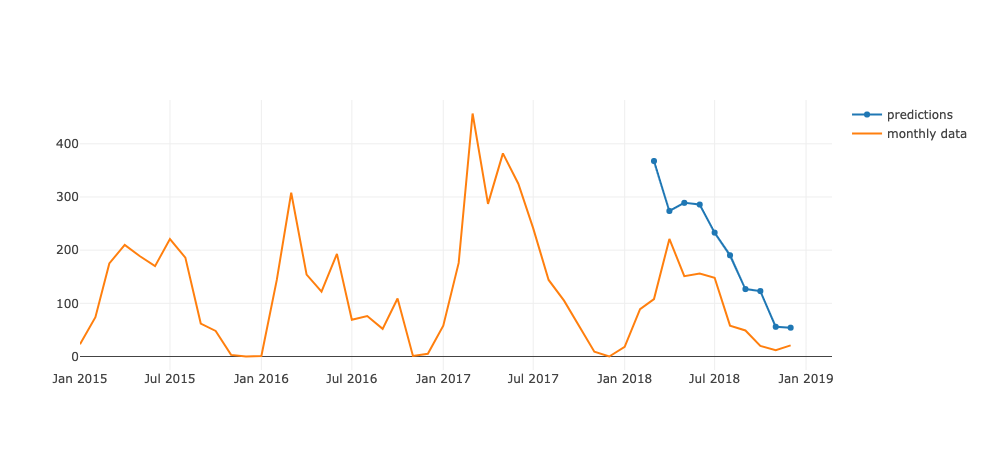

In [355]:
tc_preds = go.Scatter(x=results.ds.dt.date  , y=results.yhat.values,name='predictions')
iplot([tc_preds,trace_monthly])

In [356]:
results.error.mean()

192.21473992275736

In [348]:
pd.options.display.max_columns =200

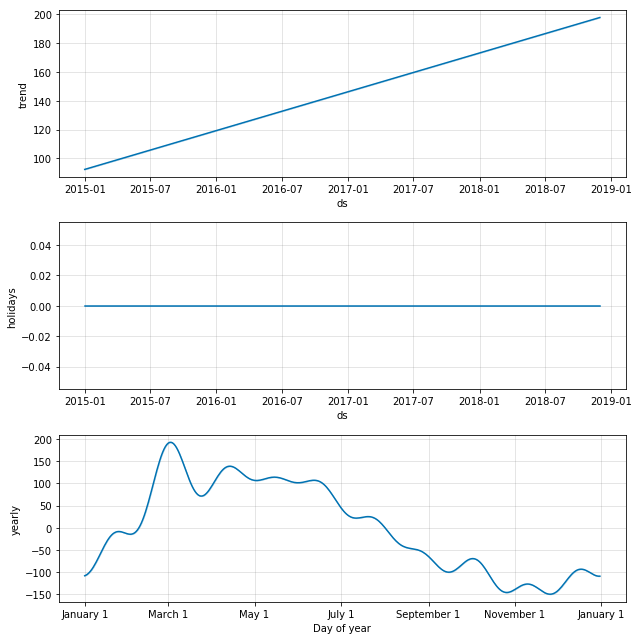

In [349]:
# When actual Holiday dates are used. We can see in the second chart that holiday effect is 0
fig = m.plot_components(forecast)

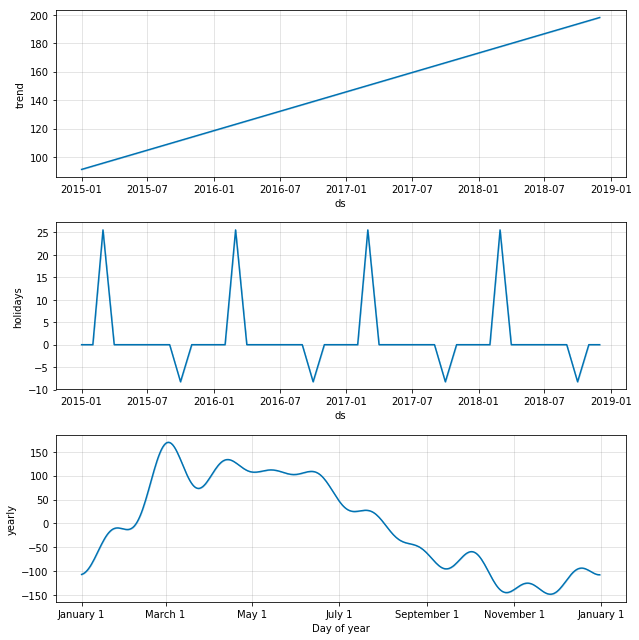

In [332]:
# When month start of holidays are used instead of actual dates, we can see that prophet has picked the holiday effect
fig = m.plot_components(forecast)